In [15]:
from haversine import haversine
from queue import PriorityQueue
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from mapgenerator import coords


## Initialization

In [16]:
class Point:
    def __init__(self,name,x,y):
        self.name = name
        self.x = x 
        self.y = y

In [17]:
class LocationNode():
    
    def __init__(self, name, latitude, longitude):
        self.name = name
        self.latitude = latitude
        self.longitude = longitude
    
    def latlong(self):
        loc = (self.latitude,self.longitude)
        return loc

In [18]:
class Graph:

    def __init__(self, names, nodes):
        # instance variables
        self.nodes = nodes
        self.adj_list = {}
        self.visited = {}
        self.parent = {}
        self.g_dist = {}
        self.names = names
        self.path=[]

        ## Default values of instance variables
        self.distance_tracker = 0.0
        
        # The for loop here is to initalize the adjacent list of each node as an 
        # empty list to which we will add
        # elements whenever we add edges. We also initalize the visited dict with 0 
        # (indicating unexplored) for each node
        for name in self.names:
            self.adj_list[name] = []
            self.visited[name] = 0
            self.parent[name] = -1
            self.g_dist[name] = 0 
        # print(self.parent)

    @staticmethod
    #The static method is a decorator. It is used because the find_distance used 
    #in the class does not relate to any object created and can work independently. 
    def _find_euclidianDistance(x1,x2,y1,y2):
        distance = ((x1-x2)**2 + (y1-y2)**2)**0.5
        return distance
    
    @staticmethod
    def _find_haversineDistance(src,dst):
        l1 = src.latlong()
        l2 = dst.latlong()
        hav = haversine(l1,l2)
        return hav
    

    # reset(self) is a class function used to reset the visited values (self.visited) of the nodes. 
    # This allows us to use multiple different algorithms without having to restart.
    def reset(self):
        for name in self.names:
            self.visited[name] = 0
            self.parent[name] = -1
            self.g_dist[name] = 0
        self.path =[]
        
            
        
    def addEdgeEuclidian(self, source, destination):
        distance = Graph._find_euclidianDistance(source.x, destination.x, source.y, destination.y)
        self.adj_list[source.name].append((destination,distance))
        self.adj_list[destination.name].append((source,distance))
        
    def addEdgeHaversine(self, source, destination):
        distance = Graph._find_haversineDistance(source,destination)
        self.adj_list[source.name].append((destination,distance))
        self.adj_list[destination.name].append((source,distance))

    # Printing the graph created
    def printGraph(self):
        for name in self.names:
            all_adjacents = self.adj_list[name]
            # print(all_adjacents)
            for neighbour,distance in all_adjacents:
                print(f"{name} -> {neighbour.name} | distance {round(distance,2)}")
    
    def dfs(self, source, destination):
        # A 'stack' data structure is used as a frontier in DFS. It is a LIFO system. 
        # last-in first-out similar to a pile of books.

        # store the source element in the stack
        stack = [source]
        self.visited[source.name] = 1 # mark as visited

        # Run a loop unitl all the nodes are explored or until the path is found
        while stack:
            # Remove the element at the top of the stack
            element = stack.pop()
            # print("Currently exploring: ",element.name)

             # Check if the element is destination, if yes the goal has been found break the loop
            if element.name == destination.name:
                # add the element being explored to the path
                self.path.append(element)
                print("Goal has been found")
                break
            
            # If not then: 
            # Loops over adjacent elements
            for neighbour, distance in self.adj_list[element.name]:
                # Checks if visited before
                if self.visited[neighbour.name] != 1:

                    stack.append(neighbour)
                    self.visited[neighbour.name] = 1 # Marks that neighbour as visited
                    self.parent[neighbour.name] = element.name

    def bfs(self, source, destination):
        queue = [source]
        self.visited[source.name] = 1

        while queue:
            element = queue.pop(0)
            # print("Currently exploring: ",element.name)
        
            if element.name == destination.name:
                self.path.append(element)
                print("Goal has been found")
                break
            
            for neighbour, distance in self.adj_list[element.name]:
                
                if self.visited[neighbour.name] != 1:

                    queue.append(neighbour)
                    self.visited[neighbour.name] = 1 # Marks that neighbour as visited
                    self.parent[neighbour.name] = element.name
    
    def best_first_searchEuclidian(self, source, destination):
        # Priority Queue is a variant of Queue that retrieves open entries in priority order (lowest first).
        # Entries are typically tuples of the form:  (priority number, data).
        pq = PriorityQueue() 
        pq.put((0,source)) 
        self.visited[source.name] = 1
        
        while pq.empty() == False: 
            element = pq.get()[1] 
            print("Currently Exploring:", element.name)
            
            if element.name == destination.name: 
                print("Goal has been found")
                break
            
            for neighbour, distance in self.adj_list[element.name]: 
                if self.visited[neighbour.name] != 1: 
                   
                    h_dist = Graph._find_euclidianDistance(neighbour.x,destination.x,neighbour.y,destination.y) 
                    
                    pq.put((h_dist, neighbour)) 
                    self.visited[neighbour.name] = 1 # Marks that neighbour as visited
                    self.parent[neighbour.name] = element.name 
                    
    
    def best_first_searchHaversine(self, source, destination):
        # Priority Queue is a variant of Queue that retrieves open entries in priority order (lowest first).
        # Entries are typically tuples of the form:  (priority number, data).
        pq = PriorityQueue()
        pq.put((0,source))
        self.visited[source.name] = 1
        
        while pq.empty() == False:
            element = pq.get()[1]
            # print("Currently Exploring:", element.name)
            
            if element.name == destination.name:
                print("Goal has been found")
                break
            
            for neighbour, distance in self.adj_list[element.name]:
                if self.visited[neighbour.name] != 1:

                    h_dist = Graph._find_haversineDistance(neighbour,destination)

                    pq.put((h_dist, neighbour))
                    self.visited[neighbour.name] = 1 # Marks that neighbour as visited
                    self.parent[neighbour.name] = element.name
                    
    def a_star_searchEuclidian(self, source, destination):
        
        pq = PriorityQueue()
        pq.put((0,source))
        self.visited[source.name] = 1
        
        while pq.empty() == False:
            element = pq.get()[1]
            print("Currently Exploring:", element.name)
            
            if element.name == destination.name:
                print("Goal has been found")
                break
            
            for neighbour, distance in self.adj_list[element.name]:
                if self.visited[neighbour.name] != 1:
                    
                    self.g_dist[neighbour.name] = self.g_dist[element.name] + distance
                    h_dist = Graph._find_euclidianDistance(neighbour.x,destination.x,neighbour.y,destination.y)
                    f_dist = self.g_dist[neighbour.name] + h_dist
                    
                    pq.put((f_dist, neighbour))
                    self.visited[neighbour.name] = 1 # Marks that neighbour as visited
                    self.parent[neighbour.name] = element.name
    
    def a_star_searchHaversine(self, source, destination):
        
        pq = PriorityQueue()
        pq.put((0,source))
        self.visited[source.name] = 1
        
        while pq.empty() == False:
            element = pq.get()[1]
            # print("Currently Exploring:", element.name)
            
            if element.name == destination.name:
                print("Goal has been found")
                break
            
            for neighbour, distance in self.adj_list[element.name]:
                if self.visited[neighbour.name] != 1:
                    
                    self.g_dist[neighbour.name] = self.g_dist[element.name] + distance
                    h_dist = Graph._find_haversineDistance(neighbour,destination)
                    f_dist = self.g_dist[neighbour.name] + h_dist
                    
                    pq.put((f_dist, neighbour))
                    self.visited[neighbour.name] = 1
                    self.parent[neighbour.name] = element.name
    
    
    def printPath(self, j):
        lst = []
        # if node inputted is the source then it will have -1
        if self.parent[j] == -1 : 
            print(j,end=" ")
            lst.append(j)
            self.path.append(j)
            return
        # If not it backtracks to parent of that node while 
        # appending the current node to path list
        self.printPath(self.parent[j]) 
        print(j,end=" ")
        self.path.append(j)
        
        return self.path
        

# Haversine Distance

In [19]:
mapPoints = coords()

A = LocationNode('A', 18.948940, 72.800114)
B = LocationNode('B', 18.952430, 72.805009)
C = LocationNode('C', 18.955162, 72.808014)
D = LocationNode('D', 18.958068, 72.809458)
E = LocationNode('E', 18.959034, 72.809951)
F = LocationNode('F', 18.961364, 72.808486)
G = LocationNode('G', 18.964083, 72.807628)
H = LocationNode('H', 18.966315, 72.807671)
I = LocationNode('I', 18.969602, 72.809387)
J = LocationNode('J', 18.976258, 72.808958)
K = LocationNode('K', 18.977711, 72.811188)
L = LocationNode('L', 18.981412, 72.814149)
M = LocationNode('M', 18.983604, 72.815265)
N = LocationNode('N', 18.987134, 72.813978)
O = LocationNode('O', 18.990543, 72.814192)
P = LocationNode('P', 18.993574, 72.814582)
Q = LocationNode('Q', 18.996171, 72.812780)
R = LocationNode('R', 18.999912, 72.811566)
S = LocationNode('S', 19.002509, 72.812090)
T = LocationNode('T', 19.004646, 72.813427)
U = LocationNode('U', 19.008640, 72.814731)
V = LocationNode('V', 19.012373, 72.816962)
W = LocationNode('W', 19.013972, 72.812956)
X = LocationNode('X', 19.016260, 72.812123)
Y = LocationNode('Y', 19.020520, 72.813024)
Z = LocationNode('Z', 19.038282, 72.817905)
AA = LocationNode('AA', 19.041284, 72.820436)
BA = LocationNode('BA', 19.043604, 72.825452)
CA = LocationNode('CA', 19.045503, 72.828385)
DA = LocationNode('DA', 19.047393, 72.827545)
EA = LocationNode('EA', 19.049016, 72.827614)
FA = LocationNode('FA', 19.050496, 72.829458)
GA = LocationNode('GA', 18.948327, 72.798081)
HA = LocationNode('HA', 18.947827, 72.797239)
IA = LocationNode('IA', 18.948852, 72.798354)
JA = LocationNode('JA', 18.954918, 72.804458)
KA = LocationNode('KA', 18.958056, 72.806611)
LA = LocationNode('LA', 18.959034, 72.807726)
MA = LocationNode('MA', 18.961124, 72.808022)
NA = LocationNode('NA', 18.949619, 72.797523)
OA = LocationNode('OA', 18.950350, 72.795913)
PA = LocationNode('PA', 18.958506, 72.800640)
QA = LocationNode('QA', 18.960958, 72.801363)
RA = LocationNode('RA', 18.964002, 72.803507)
SA = LocationNode('SA', 18.964546, 72.804477)
TA = LocationNode('TA', 18.964180, 72.806021)
UA = LocationNode('UA', 18.967265, 72.803490)
VA = LocationNode('VA', 18.970252, 72.804443)
WA = LocationNode('WA', 18.975536, 72.806844)
XA = LocationNode('XA', 18.955783, 72.809179)
YA = LocationNode('YA', 18.956148, 72.810208)
ZA = LocationNode('ZA', 18.958035, 72.811014)
AB = LocationNode('AB', 18.961615, 72.813211)
CB = LocationNode('CB', 18.963588, 72.809934)
DB = LocationNode('DB', 18.964387, 72.813030)
EB = LocationNode('EB', 18.964387, 72.813030)
FB = LocationNode('FB', 18.966035, 72.813215)
GB = LocationNode('GB', 18.969055, 72.815184)
HB = LocationNode('HB', 18.972813, 72.814587)
IB = LocationNode('IB', 18.974611, 72.813185)
JB = LocationNode('JB', 18.978486, 72.814219)
KB = LocationNode('KB', 18.979781, 72.822164)
LB = LocationNode('LB', 18.984302, 72.824746)
MB = LocationNode('MB', 18.988814, 72.822576)
NB = LocationNode('NB', 18.998399, 72.817497)
OB = LocationNode('OB', 18.995948, 72.816116)
PB = LocationNode('PB', 19.001353, 72.815773)
QB = LocationNode('QB', 19.002789, 72.829919)
RB = LocationNode('RB', 19.009119, 72.833324)
SB = LocationNode('SB', 19.020601, 72.843490)
TB = LocationNode('TB', 19.030412, 72.847170)
UB = LocationNode('UB', 19.034858, 72.847822)
VB = LocationNode('VB', 19.045795, 72.843867)
WB = LocationNode('WB', 19.045714, 72.842495)
XB = LocationNode('XB', 19.044740, 72.839278)
YB = LocationNode('YB', 19.049681, 72.838308)
ZB = LocationNode('ZB', 19.052156, 72.835735)
AC = LocationNode('AC', 19.052293, 72.834114)
BC = LocationNode('BC', 19.006291,72.821608)
CC = LocationNode('CC', 19.006311,72.818198)
DC = LocationNode('DC', 19.002846,72.815891)
EC = LocationNode('EC', 19.004084,72.816727)
FC = LocationNode('FC', 19.004928,72.817894)
GC = LocationNode('GC', 19.010673,72.820639)
HC = LocationNode('HC', 19.012536,72.822561)
IC = LocationNode('IC', 19.016268,72.829252)
JC = LocationNode('JC', 19.014077,72.830459)
KC = LocationNode('KC', 19.015794,72.834676)
LC = LocationNode('LC', 19.022021,72.834121)
MC = LocationNode('MC', 19.030119,72.838650)
NC = LocationNode('NC', 19.036805,72.838976)
OC = LocationNode('OC', 19.042485,72.840177)
PC = LocationNode('PC', 19.015514,72.833595)
RC = LocationNode('RC', 19.020642,72.836890)
SC = LocationNode('SC', 19.024602,72.840579)
TC = LocationNode('TC', 19.031288,72.842037)
UC = LocationNode('UC', 19.035020,72.842380)
VC = LocationNode('VC', 19.038525,72.842045)
XC = LocationNode('XC', 19.006117,72.830874)
YC = LocationNode('YC', 19.009192,72.830797)
ZC = LocationNode('ZC', 19.013043,72.828107)

# Creating names list
names = []
for k in mapPoints.keys():
    names.append(k)

nodes = len(names)

g = Graph(names,nodes)
g.addEdgeHaversine(A,B)
g.addEdgeHaversine(B,C)
g.addEdgeHaversine(C,D)
g.addEdgeHaversine(D,E)
g.addEdgeHaversine(E,F)
g.addEdgeHaversine(F,G)
g.addEdgeHaversine(G,H)
g.addEdgeHaversine(H,I)
g.addEdgeHaversine(I,J)
g.addEdgeHaversine(J,K)
g.addEdgeHaversine(K,L)
g.addEdgeHaversine(L,M)
g.addEdgeHaversine(M,N)
g.addEdgeHaversine(N,O)
g.addEdgeHaversine(O,P)
g.addEdgeHaversine(P,Q)
g.addEdgeHaversine(Q,R)
g.addEdgeHaversine(R,S)
g.addEdgeHaversine(S,T)
g.addEdgeHaversine(T,U)
g.addEdgeHaversine(U,V)
g.addEdgeHaversine(V,W)
g.addEdgeHaversine(W,X)
g.addEdgeHaversine(X,Y)
g.addEdgeHaversine(Y,Z)
g.addEdgeHaversine(Z,AA)
g.addEdgeHaversine(AA,BA)
g.addEdgeHaversine(BA,CA)
g.addEdgeHaversine(CA,DA)
g.addEdgeHaversine(DA,EA)
g.addEdgeHaversine(EA,FA)
g.addEdgeHaversine(A,GA)
g.addEdgeHaversine(GA,HA)
g.addEdgeHaversine(HA,IA)
g.addEdgeHaversine(IA,JA)
g.addEdgeHaversine(JA,KA)
g.addEdgeHaversine(KA,LA)
g.addEdgeHaversine(LA,MA)
g.addEdgeHaversine(MA,G)
g.addEdgeHaversine(IA,NA)
g.addEdgeHaversine(NA,OA)
g.addEdgeHaversine(OA,PA)
g.addEdgeHaversine(PA,QA)
g.addEdgeHaversine(QA,RA)
g.addEdgeHaversine(RA,SA)
g.addEdgeHaversine(SA,TA)
g.addEdgeHaversine(TA,G)
g.addEdgeHaversine(SA,UA)
g.addEdgeHaversine(UA,VA)
g.addEdgeHaversine(VA,WA)
g.addEdgeHaversine(WA,J)
g.addEdgeHaversine(XA,YA)
g.addEdgeHaversine(YA,ZA)
g.addEdgeHaversine(ZA,E)
g.addEdgeHaversine(ZA,AB)
g.addEdgeHaversine(AB,CB)
g.addEdgeHaversine(AB,DB)
g.addEdgeHaversine(DB,EB)
g.addEdgeHaversine(EB,FB)
g.addEdgeHaversine(FB,GB)
g.addEdgeHaversine(GB,HB)
g.addEdgeHaversine(HB,IB)
g.addEdgeHaversine(IB,K)
g.addEdgeHaversine(K,JB)
g.addEdgeHaversine(JB,KB)
g.addEdgeHaversine(KB,LB)
g.addEdgeHaversine(LB,MB)
g.addEdgeHaversine(MB,NB)
g.addEdgeHaversine(NB,OB)
g.addEdgeHaversine(OB,P)
g.addEdgeHaversine(NB,PB)
g.addEdgeHaversine(PB,T)
g.addEdgeHaversine(MB,QB)
g.addEdgeHaversine(QB,RB)
g.addEdgeHaversine(RB,SB)
g.addEdgeHaversine(SB,TB)
g.addEdgeHaversine(TB,UB)
g.addEdgeHaversine(UB,VB)
g.addEdgeHaversine(VB,WB)
g.addEdgeHaversine(WB,XB)
g.addEdgeHaversine(XB,YB)
g.addEdgeHaversine(YB,ZB)
g.addEdgeHaversine(ZB,AC)
g.addEdgeHaversine(AC,FA)
g.addEdgeHaversine(C,XA)
g.addEdgeHaversine(PB,DC)
g.addEdgeHaversine(DC,EC)
g.addEdgeHaversine(EC,FC)
g.addEdgeHaversine(FC,CC)
g.addEdgeHaversine(CC,BC)
g.addEdgeHaversine(CC,GC)
g.addEdgeHaversine(GC,HC)
g.addEdgeHaversine(HC,IC)
g.addEdgeHaversine(IC,JC)
g.addEdgeHaversine(IC,LC)
g.addEdgeHaversine(LC,MC)
g.addEdgeHaversine(MC,NC)
g.addEdgeHaversine(NC,OC)
g.addEdgeHaversine(OC,XB)
g.addEdgeHaversine(BC,XC)
g.addEdgeHaversine(XC,YC)
g.addEdgeHaversine(YC,KC)
g.addEdgeHaversine(JC,PC)
g.addEdgeHaversine(PC,KC)
g.addEdgeHaversine(KC,RC)
g.addEdgeHaversine(RC,SC)
g.addEdgeHaversine(SC,TC)
g.addEdgeHaversine(TC,UC)
g.addEdgeHaversine(UC,VC)
g.addEdgeHaversine(VC,OC)
g.addEdgeHaversine(NB,BC)
g.addEdgeHaversine(HC,ZC)
g.addEdgeHaversine(ZC,JC)



g.printGraph()
# mapPoints

A -> B | distance 0.64
A -> GA | distance 0.22
B -> A | distance 0.64
B -> C | distance 0.44
C -> B | distance 0.44
C -> D | distance 0.36
C -> XA | distance 0.14
D -> C | distance 0.36
D -> E | distance 0.12
E -> D | distance 0.12
E -> F | distance 0.3
E -> ZA | distance 0.16
F -> E | distance 0.3
F -> G | distance 0.32
G -> F | distance 0.32
G -> H | distance 0.25
G -> MA | distance 0.33
G -> TA | distance 0.17
H -> G | distance 0.25
H -> I | distance 0.41
I -> H | distance 0.41
I -> J | distance 0.74
J -> I | distance 0.74
J -> K | distance 0.28
J -> WA | distance 0.24
K -> J | distance 0.28
K -> L | distance 0.52
K -> IB | distance 0.4
K -> JB | distance 0.33
L -> K | distance 0.52
L -> M | distance 0.27
M -> L | distance 0.27
M -> N | distance 0.42
N -> M | distance 0.42
N -> O | distance 0.38
O -> N | distance 0.38
O -> P | distance 0.34
P -> O | distance 0.34
P -> Q | distance 0.35
P -> OB | distance 0.31
Q -> P | distance 0.35
Q -> R | distance 0.44
R -> Q | distance 0.44
R -> 

In [20]:
center = []
for vals in mapPoints.values():
    center.append(vals)

centroid = lambda x: np.sum(x,axis=0)/len(x)
center = centroid(center)
center

array([18.9953104 , 72.81886206])

In [21]:
m = folium.Map(location = center, zoom_start = 13)
coods = coords()

for k,v in coods.items():
    folium.Marker(location = v,popup = f"Node: {k} Coordinates: {v} ").add_to(m)

folium.Marker(location=coods['A'],popup="Point 1",icon=folium.Icon(color="green", icon="home")).add_to(m)
folium.Marker(location=coods['FA'],popup=f"Point 2",icon=folium.Icon(color="red", icon="home")).add_to(m)

folium.PolyLine(locations = [coods['A'],coods['B']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['B'],coods['C']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['C'],coods['D']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['D'],coods['E']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['E'],coods['F']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['F'],coods['G']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['G'],coods['H']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['H'],coods['I']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['I'],coods['J']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['J'],coods['K']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['K'],coods['L']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['L'],coods['M']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['M'],coods['N']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['N'],coods['O']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['O'],coods['P']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['P'],coods['Q']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['Q'],coods['R']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['R'],coods['S']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['S'],coods['T']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['T'],coods['U']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['U'],coods['V']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['V'],coods['W']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['W'],coods['X']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['X'],coods['Y']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['Y'],coods['Z']],color = 'black', weight = 4).add_to(m)

folium.PolyLine(locations = [coods['Z'],coods['AA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['AA'],coods['BA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['BA'],coods['CA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['CA'],coods['DA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['DA'],coods['EA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['EA'],coods['FA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['A'],coods['GA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['GA'],coods['HA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['HA'],coods['IA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['IA'],coods['JA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['JA'],coods['KA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['KA'],coods['LA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['LA'],coods['MA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['MA'],coods['G']],color = 'black', weight = 4).add_to(m)


folium.PolyLine(locations = [coods['IA'],coods['NA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['NA'],coods['OA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['OA'],coods['PA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['PA'],coods['QA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['QA'],coods['RA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['RA'],coods['SA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['SA'],coods['TA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['TA'],coods['G']],color = 'black', weight = 4).add_to(m)

folium.PolyLine(locations = [coods['SA'],coods['UA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['UA'],coods['VA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['VA'],coods['WA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['WA'],coods['J']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['XA'],coods['YA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['YA'],coods['ZA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['ZA'],coods['E']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['ZA'],coods['AB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['AB'],coods['CB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['AB'],coods['DB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['DB'],coods['EB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['EB'],coods['FB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['FB'],coods['GB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['GB'],coods['HB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['HB'],coods['IB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['IB'],coods['K']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['K'],coods['JB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['JB'],coods['KB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['KB'],coods['LB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['LB'],coods['MB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['MB'],coods['NB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['NB'],coods['OB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['OB'],coods['P']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['NB'],coods['PB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['PB'],coods['T']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['MB'],coods['QB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['QB'],coods['RB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['RB'],coods['SB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['SB'],coods['TB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['TB'],coods['UB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['UB'],coods['VB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['VB'],coods['WB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['WB'],coods['XB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['XB'],coods['YB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['YB'],coods['ZB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['ZB'],coods['AC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['AC'],coods['FA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['C'],coods['XA']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['PB'],coods['DC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['DC'],coods['EC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['EC'],coods['FC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['FC'],coods['CC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['CC'],coods['BC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['CC'],coods['GC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['GC'],coods['HC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['HC'],coods['IC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['IC'],coods['JC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['IC'],coods['LC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['LC'],coods['MC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['MC'],coods['NC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['NC'],coods['OC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['OC'],coods['XB']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['BC'],coods['XC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['XC'],coods['YC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['YC'],coods['KC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['JC'],coods['PC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['PC'],coods['KC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['KC'],coods['RC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['RC'],coods['SC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['SC'],coods['TC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['TC'],coods['UC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['UC'],coods['VC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['VC'],coods['OC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['NB'],coods['BC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['HC'],coods['ZC']],color = 'black', weight = 4).add_to(m)
folium.PolyLine(locations = [coods['ZC'],coods['JC']],color = 'black', weight = 4).add_to(m)



m


In [22]:
def general(path,printMap = False):
    
    # Store all path lists -Aryan
    distance = 0
    for i in range(len(path)-1):
        if printMap == True:
            folium.PolyLine(locations=[coods[path[i]],coods[path[i+1]]],color='blue',weight=6).add_to(m)
        
        distance += haversine(coods[path[i]],coods[path[i+1]])
        final_distanceKM = round(distance,2)
        final_distanceM = round(distance,2)*1000
    print("\n\nDistance: ")    
    print(final_distanceKM,"Kms /", final_distanceM, "m")

def a_star_searchHaversine(g,src,dest, printMap = False):
    g.reset()
    print("\nAlgorithm: a_star_searchHaversine")
    print("\nPath Being Explored: ")
    g.a_star_searchHaversine(src,dest)
    print("\nPath : ")
    path = g.printPath(dest.name)
    general(path,printMap)

def best_first_searchHaversine(g,src,dest, printMap = False):
    g.reset()
    print("-------------------------------------------------------------------")
    print("\nAlgorithm: best_first_searchHaversine")
    print("\nPath Being Explored: ")
    g.best_first_searchHaversine(src,dest)
    print("\nPath : ")
    path = g.printPath(dest.name)
    general(path,printMap)
    
def bfs(g,src,dest, printMap = False):
    g.reset()
    print("-------------------------------------------------------------------")
    print("\nAlgorithm: bfs")
    print("\nPath Being Explored: ")
    g.bfs(src,dest)
    print("\nPath : ")
    path = g.printPath(dest.name)
    path.pop(0)
    general(path,printMap)

def dfs(g,src,dest, printMap = False):
    g.reset()
    print("-------------------------------------------------------------------")
    print("\nAlgorithm: dfs")
    print("\nPath Being Explored: ")
    g.dfs(src,dest)
    print("\nPath : ")
    path = g.printPath(dest.name)
    path.pop(0)
    general(path,printMap)

def HaversineExecution(g, src, dest):
    a_star_searchHaversine(g, src, dest)
    best_first_searchHaversine(g, src, dest)
    bfs(g, src, dest)
    dfs(g, src, dest)

HaversineExecution(g, src = A, dest = FA)


Algorithm: a_star_searchHaversine

Path Being Explored: 
Goal has been found

Path : 
A B C D E F G H I J K L M N O P OB NB PB T U V W X Y Z AA BA CA DA EA FA 

Distance: 
13.46 Kms / 13460.0 m
-------------------------------------------------------------------

Algorithm: best_first_searchHaversine

Path Being Explored: 
Goal has been found

Path : 
A B C D E F G H I J K L M N O P OB NB BC XC YC KC RC SC TC UC VC OC XB YB ZB AC FA 

Distance: 
14.67 Kms / 14670.0 m
-------------------------------------------------------------------

Algorithm: bfs

Path Being Explored: 
Goal has been found

Path : 
A B C D E F G H I J K JB KB LB MB QB RB SB TB UB VB WB XB YB ZB AC FA 

Distance: 
15.43 Kms / 15430.0 m
-------------------------------------------------------------------

Algorithm: dfs

Path Being Explored: 
Goal has been found

Path : 
A GA HA IA NA OA PA QA RA SA UA VA WA J K JB KB LB MB QB RB SB TB UB VB WB XB OC VC UC TC SC RC KC PC JC ZC HC GC CC FC EC DC PB T U V W X Y Z AA BA CA

In [23]:
a_star_searchHaversine(g, src = A, dest = FA, printMap=True)
m


Algorithm: a_star_searchHaversine

Path Being Explored: 
Goal has been found

Path : 
A B C D E F G H I J K L M N O P OB NB PB T U V W X Y Z AA BA CA DA EA FA 

Distance: 
13.46 Kms / 13460.0 m


# Euclidian Distance

In [24]:
a = Point('A',1,2)
b = Point('B',3,6)
c = Point('C',5,4)
d = Point('D',1,10)
e = Point('E',6,10)
f = Point('F',11,7)

listPoints = [a,b,c,d,e,f]
xList = [1,3,5,1,6,11]
yList = [2,6,4,10,10,7]

names = ['A','B','C','D','E','F']
nodes = len(names)

g1 = Graph(names, names)

g1.addEdgeEuclidian(a,b)
g1.addEdgeEuclidian(a,c)
g1.addEdgeEuclidian(b,a)
g1.addEdgeEuclidian(b,e)
g1.addEdgeEuclidian(c,e)
g1.addEdgeEuclidian(d,f)
g1.addEdgeEuclidian(e,f)

g1.printGraph()


A -> B | distance 4.47
A -> C | distance 4.47
A -> B | distance 4.47
B -> A | distance 4.47
B -> A | distance 4.47
B -> E | distance 5.0
C -> A | distance 4.47
C -> E | distance 6.08
D -> F | distance 10.44
E -> B | distance 5.0
E -> C | distance 6.08
E -> F | distance 5.83
F -> D | distance 10.44
F -> E | distance 5.83


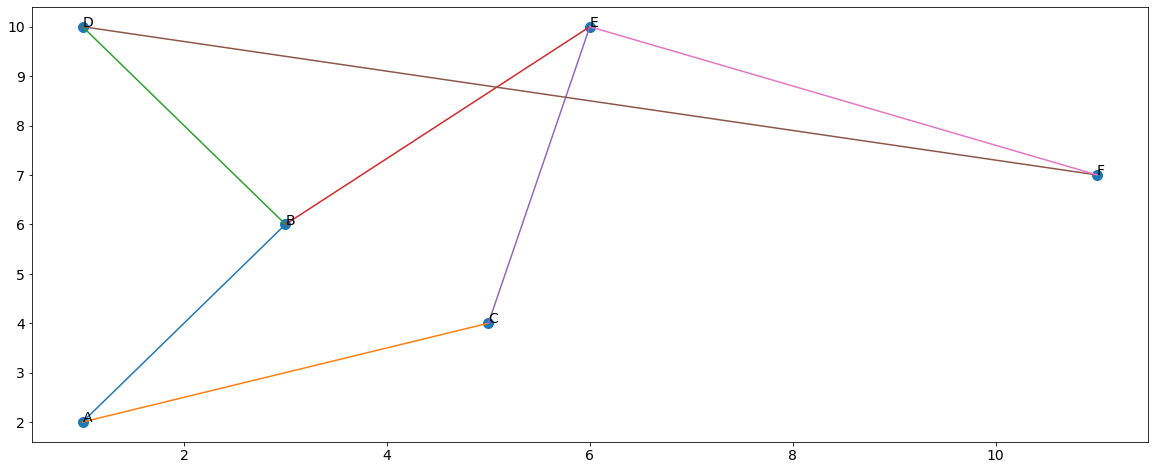

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] =(20,8)

x = [1,3,5,1,6,11]
y = [2,6,4,10,10,7]
plt.scatter(x,y,s=100)

plt.annotate('A',(x[0],y[0]))
plt.annotate('B',(x[1],y[1]))
plt.annotate('C',(x[2],y[2]))
plt.annotate('D',(x[3],y[3]))
plt.annotate('E',(x[4],y[4]))
plt.annotate('F',(x[5],y[5]))

# plt.plot([x1,x2],[y1,y2])
plt.plot([1,3],[2,6])   # A -> B
plt.plot([1,5],[2,4])   # A -> C
plt.plot([3,1],[6,10])  # B -> D
plt.plot([3,6],[6,10])  # B -> E
plt.plot([5,6],[4,10])  # C -> E
plt.plot([1,11],[10,7]) # D -> F
plt.plot([6,11],[10,7]) # E -> F

In [26]:
def printGraphMap(path,listPoints, xList, yList):
    x = xList
    y = yList
    xi = []
    yi = []
    
    coords = {a.name:[1,2], b.name:[3,6], c.name:[5,4], d.name:[1,10], e.name:[6,10], f.name:[11,7]}
    for i in path:
        for n in coords.keys():
            if i == n:
                xi.append(coords[n][0])
                yi.append(coords[n][1])

    plt.scatter(x,y,s=100)

    c1 = 0
    for point in listPoints:
        plt.annotate(point.name,(x[c1],y[c1]))
        c1 = c1+1

    plt.plot([xi[0],xi[1]],[yi[0],yi[1]])
    plt.plot([xi[1],xi[2]],[yi[1],yi[2]])
    plt.plot([xi[2],xi[3]],[yi[2],yi[3]])


def general1(path,printMap = False):
    distance = 0
    i = 0
    path_list = []

    if printMap == True:
        printGraphMap(path,listPoints, xList, yList)
    
    for name in path:
        for i in range(len(listPoints)):
            if name == listPoints[i].name:
                path_list.append((listPoints[i].x, listPoints[i].y))

    print("\n"+ str(path_list))
    
    for i in range(len(path_list)-1):
        distance += Graph._find_euclidianDistance(path_list[i][0],path_list[i+1][0],path_list[i][1],path_list[i+1][1])

    final_distanceKM = round(distance,2)
    final_distanceM = round(distance,2)*1000
    print("\n\nDistance: ")    
    print(final_distanceKM,"Kms /", final_distanceM, "m")

def a_star_searchEuclidian(g,src,dest, printMap = False):
    g.reset()
    print("\nAlgorithm: a_star_searchEuclidian")
    print("\nPath Being Explored: ")
    g.a_star_searchEuclidian(src,dest)
    print("\nPath : ")
    path = g.printPath(dest.name)
    general1(path,printMap)

def best_first_searchEuclidian(g,src,dest, printMap = False):
    g.reset()
    print("-------------------------------------------------------------------")
    print("\nAlgorithm: best_first_searchEuclidian")
    print("\nPath Being Explored: ")
    g.best_first_searchEuclidian(src,dest)
    print("\nPath : ")
    path = g.printPath(dest.name)
    general1(path,printMap)
    
def bfs(g,src,dest, printMap = False):
    g.reset()
    print("-------------------------------------------------------------------")
    print("\nAlgorithm: bfs")
    print("\nPath Being Explored: ")
    g.bfs(src,dest)
    print("\nPath : ")
    path = g.printPath(dest.name)
    path.pop(0)
    general1(path,printMap)

def dfs(g,src,dest, printMap = False):
    g.reset()
    print("-------------------------------------------------------------------")
    print("\nAlgorithm: dfs")
    print("\nPath Being Explored: ")
    g.dfs(src,dest)
    print("\nPath : ")
    path = g.printPath(dest.name)
    path.pop(0)
    general1(path,printMap)

def euclidianExecution(g, src, dest):
    a_star_searchEuclidian(g, src, dest)
    best_first_searchEuclidian(g, src, dest)
    bfs(g, src, dest)
    dfs(g, src, dest)
    
euclidianExecution(g1, src = a, dest = f)


Algorithm: a_star_searchEuclidian

Path Being Explored: 
Currently Exploring: A
Currently Exploring: C
Currently Exploring: B
Currently Exploring: E
Currently Exploring: F
Goal has been found

Path : 
A C E F 
[(1, 2), (5, 4), (6, 10), (11, 7)]


Distance: 
16.39 Kms / 16390.0 m
-------------------------------------------------------------------

Algorithm: best_first_searchEuclidian

Path Being Explored: 
Currently Exploring: A
Currently Exploring: C
Currently Exploring: E
Currently Exploring: F
Goal has been found

Path : 
A C E F 
[(1, 2), (5, 4), (6, 10), (11, 7)]


Distance: 
16.39 Kms / 16390.0 m
-------------------------------------------------------------------

Algorithm: bfs

Path Being Explored: 
Goal has been found

Path : 
A B E F 
[(1, 2), (3, 6), (6, 10), (11, 7)]


Distance: 
15.3 Kms / 15300.0 m
-------------------------------------------------------------------

Algorithm: dfs

Path Being Explored: 
Goal has been found

Path : 
A C E F 
[(1, 2), (5, 4), (6, 10), (11,

-------------------------------------------------------------------

Algorithm: bfs

Path Being Explored: 
Goal has been found

Path : 
A B E F 
[(1, 2), (3, 6), (6, 10), (11, 7)]


Distance: 
15.3 Kms / 15300.0 m


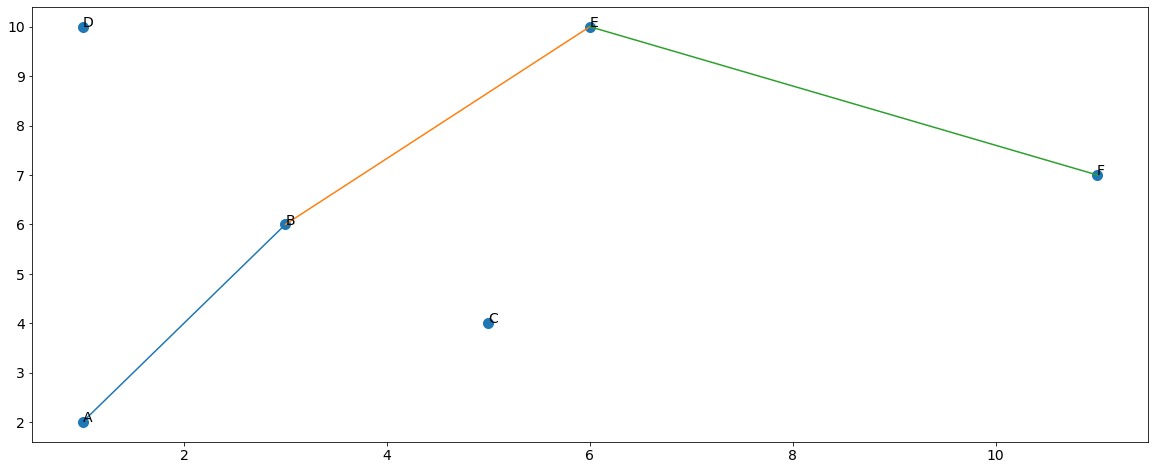

In [27]:
bfs(g1,src = a ,dest = f, printMap = True)

In [28]:
# BFS
# Steps & Explanation
'''Line 1: def bfs(self, src, dest): 
- Function definition. It takes parameters src (source node), and dest (destination node)

Line 3 - Line 5: 
queue = [src] 
self.visited[src] = 1  visited node

- Defining a list as queue (FIFO) with source placed inside it as first element (node)
- Assigning the class variable visited as 1 for the node hence marking it as a

Line 6 - Line 9: 
    while queue:  
            print(queue)  
            element = queue.pop(0) 
            print("Currently Exploring:", element) 

- A while loop which runs as long as queue is not empty.
- Prints each value of the queue
- extracts the last element of the queue as it is FIFO rule for DFS
- prints that the element extracted is being explored
- Exploration of individual nodes happens here where we extract each element as per FIFO.

Line 10 - Line 13:
    if element == dest: 
            print("Goal has been found") 
            break
            
- Checks if the element extracted above is equal to the goal state (dest)
- If so it breaks out of the loop as we have reached the goal
- Check if the element is the goal. If so exit with success statement

Line 14 - Line 18: 
    for neighbour, distance in self.adj_list[element]:
            if self.visited[neighbour] != 1:
                queue.append(neighbour)
                self.visited[neighbour] = 1
- The for loop pasrses over the nodes in the node extracted as element. If the node is visited it should ignore it.
- If any item in adjacent list of 'element' is unvisited then append to queue for further exploration and mark it as visited.'''

#DFS
# Steps & Explanation
'''Line 1: def dfs(self, src, dest): 
- Function definition. It takes parameters src (source node), and dest (destination node)

Line 3 - Line 5: 
stack = [src] 
self.visited[src] = 1  visited node

- Defining a list as stack (LIFO) with source placed inside it as first element (node)
- Assigning the class variable visited as 1 for the node hence marking it as a

Line 6 - Line 9: 
    while stack:  
            print(stack)  
            element = stack.pop() 
            print("Currently Exploring:", element) 

- A while loop which runs as long as stack is not empty.
- Prints each value of the stack
- extracts the last element of the stack as it is LIFO rule for DFS
- prints that the element extracted is being explored
- Exploration of individual nodes happens here where we extract each element as per LIFO.

Line 10 - Line 13:
    if element == dest: 
            print("Goal has been found") 
            break
            
- Checks if the element extracted above is equal to the goal state (dest)
- If so it breaks out of the loop as we have reached the goal
- Check if the element is the goal. If so exit with success statement

Line 14 - Line 18: 
    for neighbour, distance in self.adj_list[element]:
            if self.visited[neighbour] != 1:
                stack.append(neighbour)
                self.visited[neighbour] = 1
- The for loop pasrses over the nodes in the node extracted as element. If the node is visited it should ignore it.
- If any item in adjacent list of 'element' is unvisited then append to stack for further exploration and mark it as visited.'''




'Line 1: def dfs(self, src, dest): \n- Function definition. It takes parameters src (source node), and dest (destination node)\n\nLine 3 - Line 5: \nstack = [src] \nself.visited[src] = 1  visited node\n\n- Defining a list as stack (LIFO) with source placed inside it as first element (node)\n- Assigning the class variable visited as 1 for the node hence marking it as a\n\nLine 6 - Line 9: \n    while stack:  \n            print(stack)  \n            element = stack.pop() \n            print("Currently Exploring:", element) \n\n- A while loop which runs as long as stack is not empty.\n- Prints each value of the stack\n- extracts the last element of the stack as it is LIFO rule for DFS\n- prints that the element extracted is being explored\n- Exploration of individual nodes happens here where we extract each element as per LIFO.\n\nLine 10 - Line 13:\n    if element == dest: \n            print("Goal has been found") \n            break\n            \n- Checks if the element extracted abo